<h1>Trying out the copulalib python package.</h1>
<p><h3>Frank, Clayton and Gumbel copulas from 2d data.</h3></p>



<h3>Pre-setup</h3>
<p>The package is in pip, so you can conveniently just "pip copulalib". It also comes in Anaconda.</p>

<p>You may need to install a package called "statistics".</p>
<p>In order to make it work, a small fix is needed in copulalib.py, or you will get the following problem when attempting to build your copula:</p>

<img src="https://raw.githubusercontent.com/lia-statsletters/notebooks/master/img/fix_this_in_copulalib.png">

<p>The fix is simple: replace "if X.size is not Y.size" with something like:</p>

In [ ]:
        #The first assert makes sure that you are getting a 1D in X and Y
        #replace this code around line 58 in site-packages/copulalib/copulalib.py
        try:
            if X.shape[0] != Y.shape[0]:
                raise ValueError('The size of both arrays should be same.')
        except:
            raise TypeError('X and Y should have a callable shape method. '
                            'Try converting them to numpy arrays')

<p>Note: at that point I was lazily pasting the structure for some plotting ;).</p>

<h3>Testing the package</h3>
<p>The first samples (x) are generated from a beta distribution and (y) from a lognormal. Beta distributions have finite bounds for support, while the right-side support for lognormals is in the infinity. An interesting property ofcopulas: BOTH marginals are transformed to the unit range. Isn't that cool?</p>

<p>To try the package, we fitted copulas of three archimedean families (Frank, Clayton, Gumbel) to samples x and y. We then extracted some samples from the fitted copulas, and plotted the sampled outputs together with the original samples, in order to look at how they compare with each other. </p>

<p>feel free to try it out on you own, and do comment if you feel like!</p>

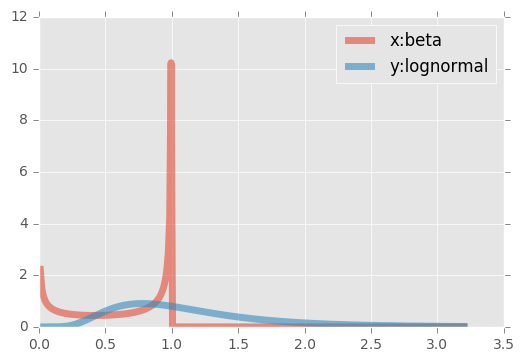

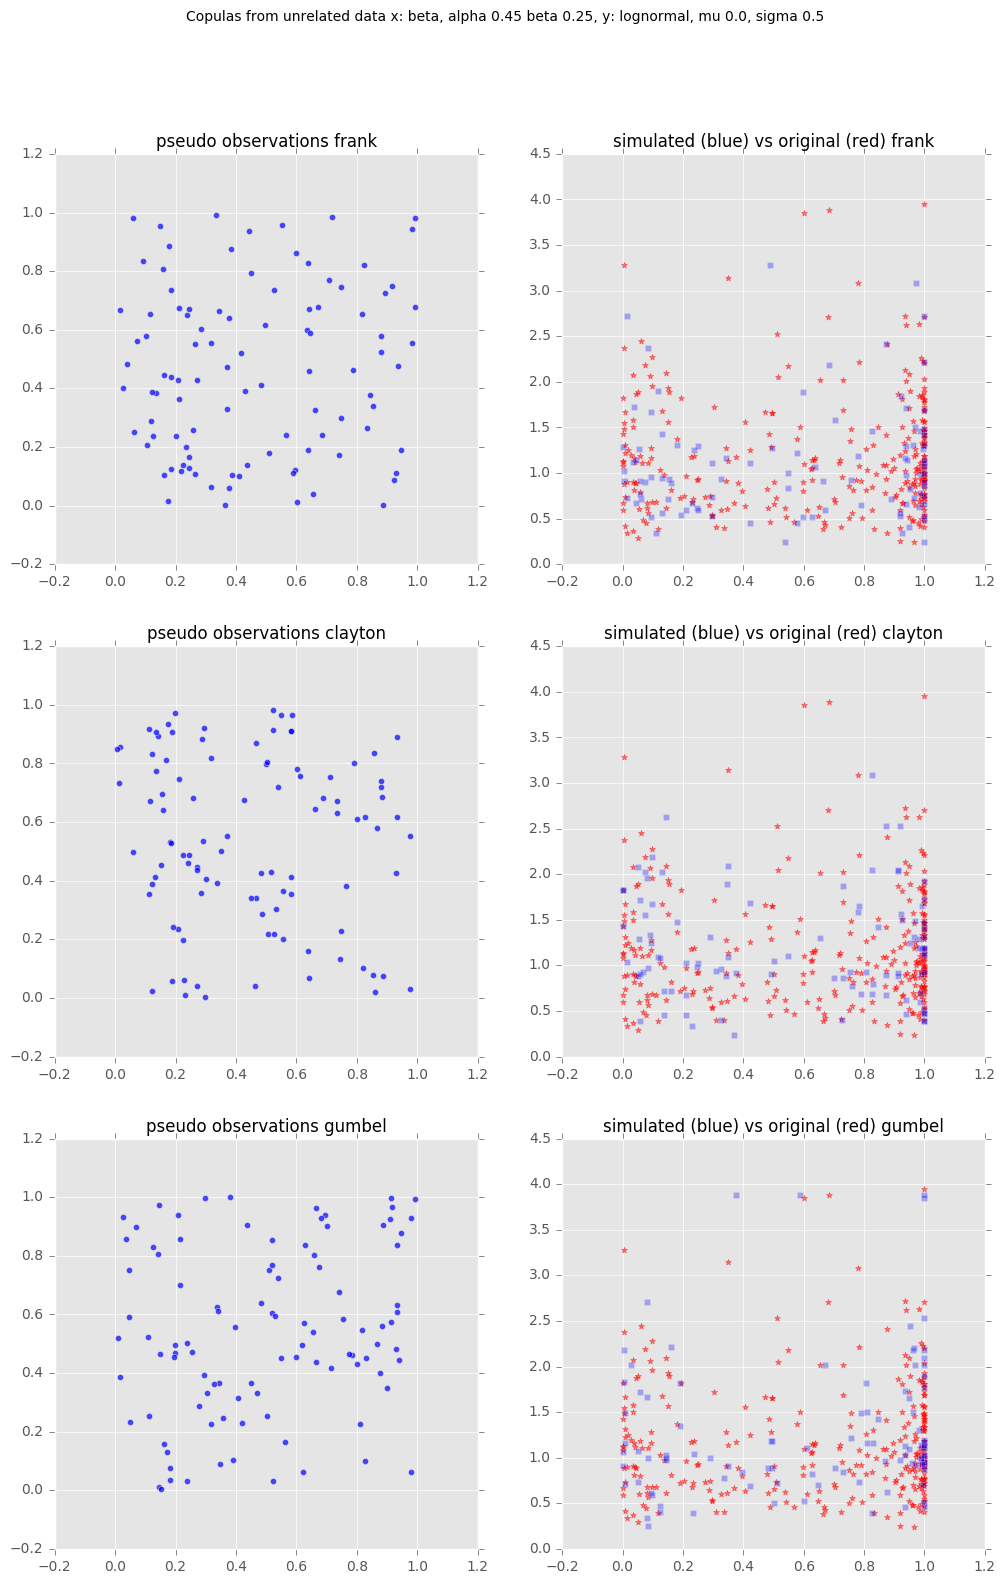

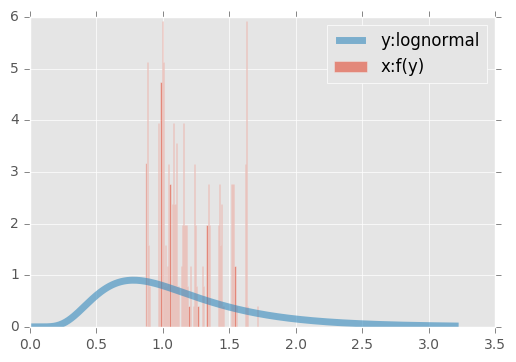

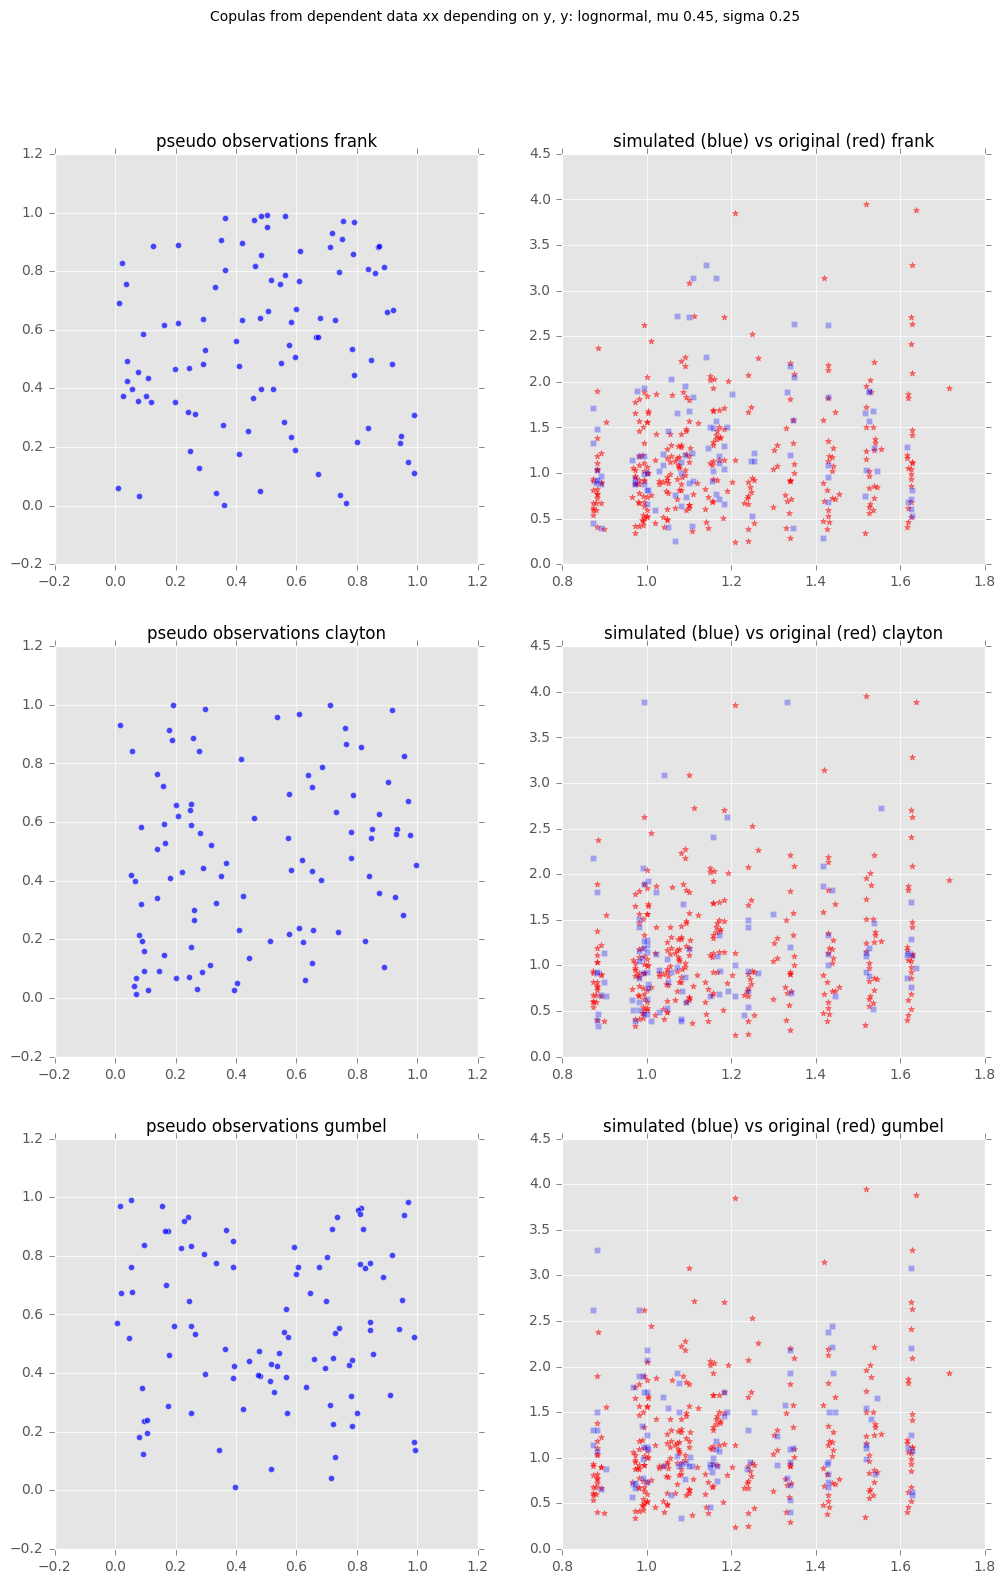

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from copulalib.copulalib import Copula as copula
from scipy.stats import beta, lognorm, gaussian_kde

plt.style.use('ggplot')

def ppf(var,q): 
    #the equivalent of ppf but built directly from data 
    sortedvar=np.sort(var)
    rcdf=np.linspace(0,1, num=len(var))
    returnable=np.array([sortedvar[np.where(rcdf<=qx)[0][-1]] for qx in q])
    #print returnable.shape
    return returnable
    

def generateAndPlot(title,x,y,howmany):
    #generate and plot
    fig, axs = plt.subplots(3,2,figsize=(12., 18.))
    fig.suptitle(title)
    for index,family in enumerate(['frank','clayton','gumbel']):
        copula_f = copula(x,y,family=family)
        try:
            #get pseudo observations
            u,v = copula_f.generate_uv(howmany)
        except Exception as exx:
            print "Could not extract pseudo observations for {}\
                   because {}".format(family, exx.message)
            continue
        #plot pseudo observations
        axs[index][0].scatter(u,v,marker='o',alpha=0.7)
        axs[index][0].set_title('pseudo observations {}'.format(family),
                                 fontsize=12)
        #plot inverse ppf
        #ux = beta.ppf(u,a,b,loc=loc)
        #vy= lognorm.ppf(v,sc,loc=loc)
        ux=ppf(x,u)
        vy=ppf(y,v)
        axs[index][1].scatter(x,y,marker='*',color='r', alpha=0.5) #original samples
        axs[index][1].scatter(ux,vy,marker='s', alpha=0.3) #simulated realisations
        axs[index][1].set_title('simulated (blue) vs original (red) {}'.format(family),
                                fontsize=12)

    plt.show()

#total samples vs pseudo observations
pseudoobs=100
sz=300
#unrelated data: a beta (x) and a lognormal (y)

loc=0.0
a= 0.45#2. #alpha
b=0.25#5. #beta
x=beta.rvs(a,b,loc=loc,size=sz)
sc=0.5
y=lognorm.rvs(sc,loc=loc, size=sz)

#plot distributions from which we sampled
t = np.linspace(0, lognorm.ppf(0.99, sc), sz)
plt.plot(t, beta.pdf(t,a,b), lw=5, alpha=0.6, label='x:beta')
plt.plot(t, lognorm.pdf(t, sc), lw=5, alpha=0.6, label='y:lognormal')
plt.legend()

#plot unrelated data
title='Copulas from unrelated data x: beta, alpha {} beta {}, y: lognormal, mu {}, sigma {}'.format(a,b,loc,sc)
generateAndPlot(title,x,y,pseudoobs)

#related data: a lognormal (y)

#plot related data
title='Copulas from dependent data xx depending on y, y: lognormal, mu {}, sigma {}'.format(a,b,loc,sc)
xx=[]
jumps=[0.001,0.01,0.1]

for indx,yi in enumerate(y):
    if indx>1:
        if yi>y[indx-1]:
            xx.append(xx[-1]+np.random.choice(jumps))
        else:
            xx.append(xx[-1]-np.random.choice(jumps))
    else:
        xx.append(1)
xx=np.array(xx)
gkxx=gaussian_kde(xx)
t = np.linspace(0, lognorm.ppf(0.99, sc), sz)
#plt.plot(t, gkxx.pdf(t), lw=5, alpha=0.6, label='x:f(y)')
plt.hist(xx,normed=True,label='x:f(y)',alpha=0.6,bins=100)
plt.plot(t, lognorm.pdf(t, sc), lw=5, alpha=0.6, label='y:lognormal')
plt.legend()
generateAndPlot(title,xx,y,pseudoobs)
